Train: 1960-02-29 → 2005-09-30  (548)
Test : 2005-10-31  → 2025-05-31   (236)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}  (mean CV AUC = 0.931)

=== Logistic Regression (best-CV, 0.50 cut) ===
              precision    recall  f1-score   support

           0      0.933     0.640     0.759       175
           1      0.457     0.869     0.599        61

    accuracy                          0.699       236
   macro avg      0.695     0.754     0.679       236
weighted avg      0.810     0.699     0.718       236

Confusion Matrix:
 [[112  63]
 [  8  53]]
ROC AUC: 0.793


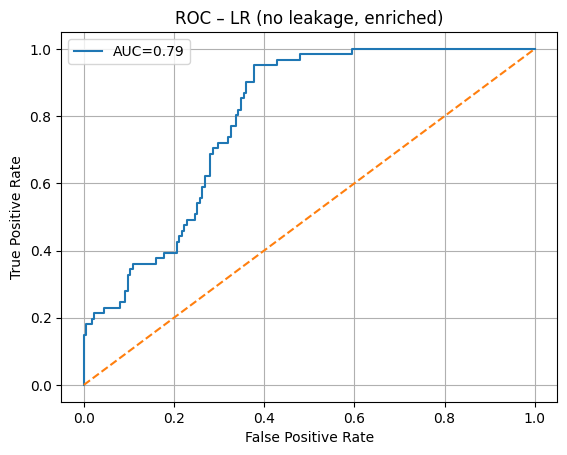


Best F0.5 = 0.521 at threshold = 0.35

=== LR @ F0.5-optimal cut ===
              precision    recall  f1-score   support

           0      0.973     0.623     0.760       175
           1      0.468     0.951     0.627        61

    accuracy                          0.708       236
   macro avg      0.720     0.787     0.693       236
weighted avg      0.843     0.708     0.725       236

Confusion Matrix:
 [[109  66]
 [  3  58]]


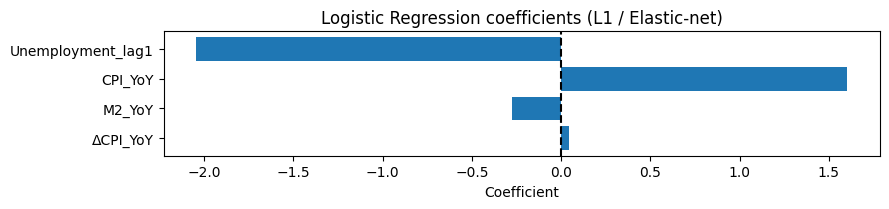

In [1]:
"""
Regime-shift classifier (inflation) – V3
----------------------------------------

Fixes / Improvements
1.  *No leakage* – drops 'Zscore'.
2.  Adds 1-period lags and month-to-month deltas for all numeric drivers.
3.  LogisticRegression search across **L1** *and* **Elastic-net** penalties.
4.  PR-curve threshold picked by **F0.5** (precision-weighted) with NaN-safe code.
"""

# -------------------------------------------------------------------
# 0. Imports
# -------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve,
                             precision_recall_curve)

# -------------------------------------------------------------------
# 1. Load & basic cleaning
# -------------------------------------------------------------------
data_path = r"C:\Users\ghkjs\GitHub\regime-shift-classification\data\processed\inflation_regime_dataset.csv"
df = (
    pd.read_csv(data_path, index_col=0, parse_dates=True)
      .sort_index()
)

# -------------------------------------------------------------------
# 2.  Quick feature-engineering
#     (a) 1-period lag  (b) month-to-month Δ
# -------------------------------------------------------------------
drivers = df.drop(columns=["Inflation_Regime", "Zscore"]).columns

for col in drivers:
    df[f"{col}_lag1"] = df[col].shift(1)
    df[f"Δ{col}"]     = df[col] - df[col].shift(1)

df = df.dropna()     # drop first row where lag/delta NA

# -------------------------------------------------------------------
# 3.  Define X & y, remove leakage
# -------------------------------------------------------------------
X = df.drop(columns=["Inflation_Regime", "Zscore"])
y = df["Inflation_Regime"]

# -------------------------------------------------------------------
# 4. Chronological split (70/30)
# -------------------------------------------------------------------
cut = int(len(df) * 0.70)
X_train, X_test = X.iloc[:cut], X.iloc[cut:]
y_train, y_test = y.iloc[:cut], y.iloc[cut:]

print(f"Train: {X_train.index.min().date()} → {X_train.index.max().date()}  ({len(X_train)})")
print(f"Test : {X_test.index.min().date()}  → {X_test.index.max().date()}   ({len(X_test)})\n")

# -------------------------------------------------------------------
# 5.  Pre-processing pipeline
# -------------------------------------------------------------------
imputer = IterativeImputer(random_state=42, max_iter=10, initial_strategy="median")
scaler  = StandardScaler()

base_lr = LogisticRegression(
    class_weight="balanced",
    max_iter=4000,
    random_state=42
)

pipe = Pipeline([
    ("imputer", imputer),
    ("scaler",  scaler),
    ("clf",     base_lr)
])

# -------------------------------------------------------------------
# 6.  Hyper-parameter grid – L1 & Elastic-net
# -------------------------------------------------------------------
param_grid = [
    {
        "clf__penalty": ["l1"],
        "clf__solver" : ["liblinear"],
        "clf__C"      : [0.1, 0.3, 0.5, 1.0, 3.0, 10.0]
    },
    {
        "clf__penalty"  : ["elasticnet"],
        "clf__solver"   : ["saga"],
        "clf__l1_ratio" : [0.3, 0.5, 0.7],
        "clf__C"        : [0.1, 0.3, 0.5, 1.0, 3.0, 10.0]
    }
]

tscv = TimeSeriesSplit(n_splits=5)

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=tscv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
).fit(X_train, y_train)

print(f"Best params: {grid.best_params_}  (mean CV AUC = {grid.best_score_:.3f})")

best_model = grid.best_estimator_

# -------------------------------------------------------------------
# 7. Evaluate on hold-out (default 0.5)
# -------------------------------------------------------------------
probs = best_model.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)

print("\n=== Logistic Regression (best-CV, 0.50 cut) ===")
print(classification_report(y_test, preds, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, preds))
print("ROC AUC:", roc_auc_score(y_test, probs).round(3))

# ROC curve
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, probs):.2f}")
plt.plot([0,1],[0,1],'--')
plt.title("ROC – LR (no leakage, enriched)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.grid(True); plt.legend(); plt.show()

# -------------------------------------------------------------------
# 8. Precision-Recall → choose F0.5-optimal threshold
# -------------------------------------------------------------------
prec, rec, thr = precision_recall_curve(y_test, probs)
beta = 0.5
fbeta = (1+beta**2) * (prec[:-1]*rec[:-1]) / (beta**2*prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(fbeta)
best_thr = thr[best_idx]
print(f"\nBest F{beta:g} = {fbeta[best_idx]:.3f} at threshold = {best_thr:.2f}")

pred_opt = (probs >= best_thr).astype(int)
print(f"\n=== LR @ F{beta:g}-optimal cut ===")
print(classification_report(y_test, pred_opt, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred_opt))

# -------------------------------------------------------------------
# 9.  Coefficient plot (skip zeroed vars)
# -------------------------------------------------------------------
coef  = best_model.named_steps["clf"].coef_.ravel()
names = X.columns
coef_df = (
    pd.DataFrame({"feature": names, "coef": coef, "abs": np.abs(coef)})
      .query("abs > 1e-6")            # keep non-zero
      .sort_values("abs")
)

plt.figure(figsize=(9, 0.3*len(coef_df)+1))
plt.barh(coef_df["feature"], coef_df["coef"])
plt.axvline(0, ls="--", c="k")
plt.title("Logistic Regression coefficients (L1 / Elastic-net)")
plt.xlabel("Coefficient"); plt.tight_layout(); plt.show()
